In [1]:
import transformers
import math
import ast
import numpy as np
import os 
import random
import tokenizers
from transformers import AutoModelForCausalLM, AutoTokenizer, Qwen2Config, TextStreamer, TextIteratorStreamer, TrainingArguments
from transformers import TrainerCallback
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.nn.functional as F
import os 
import pandas as pd 
import datasets
from datasets import load_dataset, Dataset
import requests
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["HF_DATASETS_CACHE"] = "/mnt/c/Users/Rpipc/Desktop/llama/farbod/cache"
from unsloth import FastLanguageModel
from unsloth import is_bfloat16_supported
from trl import SFTTrainer
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from sklearn.model_selection import train_test_split
from evaluate import load
import json
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from functools import partial

/home/rpipc/anaconda3/envs/LLM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
seed = 42
# np.random.default_rng = seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

bleu = load("bleu")
rouge = load("rouge")
meteor = load("meteor")

[nltk_data] Downloading package wordnet to /home/rpipc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/rpipc/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/rpipc/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [19]:
def split_chat_template(example):
    if "<|start_header_id|>assistant<|end_header_id|>\n" in example["text"]:
        parts = example["text"].split("<|start_header_id|>assistant<|end_header_id|>\n")
        return {"input": parts[0].strip(), "label": parts[1].split('\n<|eot_id|>')[0].strip()}
    else:
        return {"input": example["text"], "label": ""}  
        
def tokenize_chat_data(example, tokenizer):
    inputs = tokenizer(
        example["input"], 
        # padding="max_length", 
        # padding=False,
        padding='longest',
        # truncation=False, 
        # return_tensors="pt",
        # max_length = 8192
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            example["label"], 
            # padding="max_length",
            # padding=False,
            padding='longest',
            # truncation=False, 
            # return_tensors="pt"
            # max_length = 8192
        )
    # print(inputs)
    # print(labels)
    inputs["labels"] = labels["input_ids"]
    # inputs["input_ids"] = torch.cat(inputs["input_ids"], dim=0)
    # inputs["attention_mask"] = torch.cat(inputs["attention_mask"], dim=0)
    # inputs["labels"] = torch.cat(inputs["labels"], dim=0)
    return inputs

def compute_metrics(eval_pred, tokenizer, dataset):
    logits, labels = eval_pred
    print('logits', logits.shape)
    print('labels', labels.shape)
    org_labels = dataset["labels"]
    predictions = logits.argmax(axis=-1)
    print('predictions', predictions.shape)

    results = {}

    # Token-Level Accuracy Function (Custom)
    def compute_token_accuracy(predicted_ids, label_ids):
        total_tokens = 0
        correct_tokens = 0

        for pred, ref in zip(predicted_ids, label_ids):
            for p_token, r_token in zip(pred, ref):
                if r_token != -100:  
                    total_tokens += 1
                    if p_token == r_token:
                        correct_tokens += 1

        return (correct_tokens / total_tokens) * 100 if total_tokens > 0 else 0.0

    # 1. Loss and Perplexity
    if labels is not None:
        logits_tensor = torch.tensor(logits)
        labels_tensor = torch.tensor(labels)

        per_sample_losses = []
        for sample_logits, sample_labels in zip(logits_tensor, labels_tensor):
            loss = F.cross_entropy(
                sample_logits.view(-1, sample_logits.size(-1)),
                sample_labels.view(-1),
                reduction="none"
            )
            per_sample_loss = loss.view(sample_labels.size(0), -1).mean(dim=1).mean().item()
            per_sample_losses.append(per_sample_loss)

        results["manual_eval_loss"] = sum(per_sample_losses) / len(per_sample_losses)
        results["perplexity"] = math.exp(results["manual_eval_loss"])
        results["loss_per_sample"] = per_sample_losses

    # 2. Token-Level Metrics
    if labels is not None:
        flattened_preds = []
        flattened_labels = []
        for pred, label in zip(predictions, labels):
            for p_token, l_token in zip(pred, label):
                if l_token != -100:  
                    flattened_preds.append(p_token)
                    flattened_labels.append(l_token)

        if flattened_labels and flattened_preds:
            # Accuracy using sklearn's accuracy_score
            results["accuracy_score"] = accuracy_score(flattened_labels, flattened_preds)

            # Accuracy using the custom function
            results["token_accuracy"] = compute_token_accuracy(predictions, labels)

            # Other token-level metrics
            results["precision"] = precision_score(flattened_labels, flattened_preds, average="macro")
            results["recall"] = recall_score(flattened_labels, flattened_preds, average="macro")
            results["f1"] = f1_score(flattened_labels, flattened_preds, average="macro")

    # 3. Decoded Text-Based Metrics
    # if hasattr(trainer, 'tokenizer'):
    #     tokenizer = trainer.tokenizer
    # else:
    #     raise ValueError("Tokenizer not found in trainer context.")

    # tokenizer = trainer.processing_class.tokenizer
    
    if hasattr(tokenizer, "batch_decode"):
        decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)

        if labels is not None:
            decoded_labels = tokenizer.batch_decode(org_labels, skip_special_tokens=True)

            def compute_exact_match(predictions, references):
                matches = [
                    pred.strip() == ref.strip()
                    for pred, ref in zip(predictions, references)
                ]
                return sum(matches) / len(matches) * 100

            results["exact_match"] = compute_exact_match(decoded_predictions, decoded_labels)

            # BLEU
            results["bleu"] = bleu.compute(
                predictions=[pred.strip() for pred in decoded_predictions],
                references=[[ref.strip()] for ref in decoded_labels]
            )["bleu"]

            # # ROUGE
            rouge_results = rouge.compute(
                predictions=[pred.strip() for pred in decoded_predictions],
                references=[ref.strip() for ref in decoded_labels]
            )
            # Accessing ROUGE scores
            results["rouge1"] = rouge_results["rouge1"] if "rouge1" in rouge_results else 0.0
            results["rouge2"] = rouge_results["rouge2"] if "rouge2" in rouge_results else 0.0
            results["rougeL"] = rouge_results["rougeL"] if "rougeL" in rouge_results else 0.0
            results["rougeLsum"] = rouge_results["rougeLsum"] if "rougeLsum" in rouge_results else 0.0
            
                    # METEOR
            results["meteor"] = meteor.compute(
                predictions=[pred.strip() for pred in decoded_predictions],
                references=[[ref.strip()] for ref in decoded_labels]
            )["meteor"]

    return results
    
class SaveMetricsCallback(TrainerCallback):
    def __init__(self, output_dir):
        super().__init__()
        self.output_dir = output_dir
        self.metrics_log_path = os.path.join(self.output_dir, "eval_metrics_log.json")
        self.tensorboard_dir = os.path.join(self.output_dir, "tensorboard_logs")
        self.writer = SummaryWriter(self.tensorboard_dir)
        os.makedirs(self.output_dir, exist_ok=True)

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        """
        Triggered after each evaluation step during training.
        Saves metrics to individual files, appends them to an aggregated log, 
        and logs to TensorBoard.
        """
        if metrics:
            eval_step = state.global_step
            metrics["step"] = eval_step  # Add step information

            # Save metrics for this specific step in a separate JSON file
            step_metrics_path = os.path.join(self.output_dir, f"eval_metrics_step_{eval_step}.json")
            with open(step_metrics_path, "w") as f:
                json.dump(metrics, f, indent=4)
            print(f"Saved evaluation metrics for step {eval_step} to {step_metrics_path}")

            # Append metrics to the aggregated log file
            if os.path.exists(self.metrics_log_path):
                with open(self.metrics_log_path, "r") as f:
                    log = json.load(f)
            else:
                log = []

            log.append(metrics)

            with open(self.metrics_log_path, "w") as f:
                json.dump(log, f, indent=4)
            print(f"Appended evaluation metrics for step {eval_step} to {self.metrics_log_path}")

            # Log metrics to the console
            print(f"\n--- Evaluation Metrics at Step {eval_step} ---")
            for key, value in metrics.items():
                print(f"{key}: {value}")
            print(f"---------------------------------------------\n")

            # Log metrics to TensorBoard
            for key, value in metrics.items():
                if key != "step" and isinstance(value, (int, float)):  # Log only numeric values
                    self.writer.add_scalar(key, value, eval_step)
            print(f"Logged metrics for step {eval_step} to TensorBoard.")

    def on_train_end(self, args, state, control, **kwargs):
        """
        Closes the TensorBoard writer when training ends.
        """
        self.writer.close()
        print(f"TensorBoard logs saved to {self.tensorboard_dir}.")

def plot_and_save_metrics(metrics, output_dir, dataset_name="predict"):
    """
    Plots each metric separately and saves them as images in the specified output directory.
    Args:
        metrics (dict): A dictionary of metrics computed for the prediction dataset.
        output_dir (str): Directory to save the images.
        dataset_name (str): Name of the dataset being processed (e.g., "predict").
    """
    plots_dir = os.path.join(output_dir, f"{dataset_name}_metrics_plots")
    os.makedirs(plots_dir, exist_ok=True)

    # Iterate over each metric and plot it
    for metric, value in metrics.items():
        if isinstance(value, (int, float)):  
            plt.figure(figsize=(8, 5))
            plt.bar([metric], [value], color='blue')
            plt.title(f"{metric.capitalize()} ({dataset_name.capitalize()} Dataset)")
            plt.ylabel("Value")
            plt.grid(axis="y", linestyle="--", alpha=0.7)
            plt.tight_layout()

            # Save the plot as an image
            save_path = os.path.join(plots_dir, f"{metric}.png")
            plt.savefig(save_path)
            plt.close()
            print(f"Saved plot for {metric} to {save_path}")



def load_latest_eval_metrics(output_dir):
    """
    Loads the latest evaluation metrics from the cumulative log file.
    Args:
        output_dir (str): Directory where evaluation metrics are saved.
    Returns:
        dict: Metrics for the most recent evaluation step.
    """
    log_path = os.path.join(output_dir, "eval_metrics_log.json")

    with open(log_path, "r") as f:
        metrics_log = json.load(f)

    # Get the last recorded metrics
    latest_metrics = metrics_log[-1]
    print(f"Loaded metrics for step {latest_metrics['step']}")
    return latest_metrics


def plot_eval_trends(log_path):
    """
    Plots trends for all metrics across evaluation steps.
    Args:
        log_path (str): Path to the cumulative evaluation metrics log file.
    """
    with open(log_path, "r") as f:
        metrics_log = json.load(f)

    steps = [entry["step"] for entry in metrics_log]
    all_metrics = {key: [] for key in metrics_log[0] if key != "step"}

    for entry in metrics_log:
        for key, value in entry.items():
            if key != "step" and isinstance(value, (int, float)):
                all_metrics[key].append(value)

    # Combined plot for all metrics
    plt.figure(figsize=(12, 8))
    for metric, values in all_metrics.items():
        plt.plot(steps, values, label=metric)
    plt.xlabel("Evaluation Step")
    plt.ylabel("Metric Value")
    plt.title("Evaluation Metrics Trends")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Separate plots for each metric
    for metric, values in all_metrics.items():
        plt.figure(figsize=(8, 5))
        plt.plot(steps, values, label=metric, marker='o')
        plt.xlabel("Training Step")
        plt.ylabel(metric)
        plt.title(f"{metric} Over Training Steps")
        plt.grid(True)
        plt.tight_layout()
        plt.legend()
        plt.show()


def save_eval_trends(log_path, output_dir):
    """
    Saves individual trend plots for each metric across evaluation steps.
    Args:
        log_path (str): Path to the cumulative evaluation metrics log file.
        output_dir (str): Directory to save the plots.
    """
    plots_dir = os.path.join(output_dir, "eval_trend_plots")
    os.makedirs(plots_dir, exist_ok=True)

    with open(log_path, "r") as f:
        metrics_log = json.load(f)

    steps = [entry["step"] for entry in metrics_log]
    all_metrics = {key: [] for key in metrics_log[0] if key != "step"}

    for entry in metrics_log:
        for key, value in entry.items():
            if key != "step" and isinstance(value, (int, float)):
                all_metrics[key].append(value)

    for metric, values in all_metrics.items():
        plt.figure(figsize=(8, 5))
        plt.plot(steps, values, label=metric, marker='o')
        plt.xlabel("Evaluation Step")
        plt.ylabel(metric)
        plt.title(f"{metric.capitalize()} Trend")
        plt.grid(True)
        plt.tight_layout()
        save_path = os.path.join(plots_dir, f"{metric}.png")
        plt.savefig(save_path)
        print(f"Saved trend plot for {metric} to {save_path}")
        plt.close()

In [4]:
main_results_path = '/mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit'
if not os.path.exists(main_results_path):
    os.makedirs(main_results_path, exist_ok=True)

persian_json_data = '/mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/datas/fa/davodi.csv'
persian_df = pd.read_csv(persian_json_data)
persian_df.drop_duplicates(inplace=True)

prop_roles = set()
for _, row in persian_df.iterrows():
        prop_str = ast.literal_eval(row['propBankTags'])
        prop_roles.update(prop_str)
prop_roles = list(prop_roles)

frame_roles = set()
for _, row in persian_df.iterrows():
    framenet_str = ast.literal_eval(row['frameNetTags'])
    frame_roles.update(framenet_str)
frame_roles = list(frame_roles)

persian_df_tr, persian_df_temp = train_test_split(persian_df, random_state=seed, test_size=.08)
persian_df_val, persian_df_te = train_test_split(persian_df_temp, random_state=seed, test_size=.05)
del persian_df_temp
persian_df_tr.reset_index(drop=True, inplace=True)
persian_df_val.reset_index(drop=True, inplace=True)
persian_df_te.reset_index(drop=True, inplace=True)
persian_df_te.to_csv(os.path.join(main_results_path, "persian_df_test.csv"), index=False)
print(persian_df_tr.shape)
print(persian_df_val.shape)
print(persian_df_te.shape)
persian_df_tr = Dataset.from_pandas(persian_df_tr)
persian_df_val = Dataset.from_pandas(persian_df_val)
persian_df_te = Dataset.from_pandas(persian_df_te)


(30090, 3)
(2486, 3)
(131, 3)


In [5]:
max_seq_length = 8192 
dtype = None 
load_in_4bit = True # 
model_path = '/mnt/c/Users/Rpipc/Desktop/llama/Llama-3.2-3B-Instruct-bnb-4bit'

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_path, 
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2024.12.11: Fast Llama patching. Transformers: 4.46.3.
   \\   /|    GPU: NVIDIA GeForce RTX 3060. Max memory: 12.0 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1. CUDA: 8.6. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [6]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.12.11 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [20]:
frame_prompt_template = """<|start_header_id|>system<|end_header_id|>
Please generate FrameNet roles for the provided text.
<|eot_id|><|start_header_id|>user<|end_header_id|>
You are an expert in the field of Semantic Role Labeling and lexical resources especially FrameNet.
You know anything about how to label sentence tokens with FrameNet frame elements.
Please use the following text:"+ {}+"Here are the frame elements you have to use for labeling:" + {}+"
Your task is to generate frame elements for the provided text.
The output should be a list of frame elements in a list format. IF the token do not have any frame element, put 'O'.
Make sure that you do NOT use any elements other than the ones I provided in this prompt.
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
{}
"""

prop_prompt_template = """<|start_header_id|>system<|end_header_id|>
Please generate PropBank roles for the provided text.
<|eot_id|><|start_header_id|>user<|end_header_id|>
You are an expert in the field of Semantic Role Labeling and lexical resources especially PropBank.
You know anything about how to label sentence tokens with PropBank roles.
Please use the following text:"+ {}+"Here are the propbank roles you have to use for labeling:" + {}+"
Your task is to generate PropBank roles for the provided text.
The output should be a list of roles in a list format. IF a token does not have any role, put 'O'.
Make sure that you do NOT use any roles other than the ones I provided in this prompt.
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
{}
"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_function(examples):
    words = examples["words"]
    frams = examples["frameNetTags"]
    props = examples["propBankTags"]
    texts = []

    # Generate FrameNet prompts
    for word, fram in zip(words, frams):
        text = frame_prompt_template.format(word, str(frame_roles), fram) + EOS_TOKEN
        
        texts.append(text)

    # Generate PropBank prompts
    for word, prop in zip(words, props):
        text = prop_prompt_template.format(word, str(prop_roles), prop) + EOS_TOKEN
        texts.append(text)

    return {"text": texts}

main_dataset = persian_df_tr.map(formatting_prompts_function, remove_columns=persian_df_tr.column_names, batched=True,)
eval_dataset = persian_df_val.map(formatting_prompts_function, remove_columns=persian_df_val.column_names, batched=True,) 
test_dataset = persian_df_te.map(formatting_prompts_function, remove_columns=persian_df_te.column_names, batched=True,) 

main_dataset = main_dataset.shuffle(seed=seed)
eval_dataset = eval_dataset.shuffle(seed=seed)
test_dataset = test_dataset.shuffle(seed=seed)
#
main_dataset = main_dataset.select(range(1))
eval_dataset = eval_dataset.select(range(2))
test_dataset = test_dataset.select(range(10))
#
processed_eval_dataset = eval_dataset.map(split_chat_template)
tokenized_eval_dataset = processed_eval_dataset.map(
    partial(tokenize_chat_data, tokenizer=tokenizer), 
    batched=True, 
    remove_columns=['input', 'label']
)
# Set the format to PyTorch tensors
tokenized_eval_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# tokenized_eval_dataset = tokenized_eval_dataset.remove_columns(['input_ids', 'attention_mask'])

# Preprocess predict dataset
processed_predict_dataset = test_dataset.map(split_chat_template, remove_columns=['text'])
tokenized_predict_dataset = processed_predict_dataset.map(
    partial(tokenize_chat_data, tokenizer=tokenizer), 
    batched=True, 
    remove_columns=['input', 'label']
)
# tokenized_predict_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map: 100%|██████████| 10/10 [00:00<00:00, 346.83 examples/s]


In [65]:
tokenized_predict_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 2
})

In [57]:
print(type(tokenized_eval_dataset['input_ids']))

<class 'torch.Tensor'>


In [58]:
tokenized_eval_dataset['input_ids'].size()

torch.Size([2, 6781])

In [122]:
hf_dataset = Dataset.from_dict({
    'input_ids': torch.tensor(tokenized_predict_dataset["input_ids"]),
    'labels': torch.tensor(tokenized_predict_dataset["labels"])
})

In [121]:
tokenized_predict_dataset['input_ids']

[[128000,
  128006,
  9125,
  128007,
  198,
  5618,
  7068,
  3998,
  26913,
  13073,
  369,
  279,
  3984,
  1495,
  627,
  128009,
  128006,
  882,
  128007,
  198,
  2675,
  527,
  459,
  6335,
  304,
  279,
  2115,
  315,
  75433,
  15766,
  9587,
  287,
  323,
  78686,
  5070,
  5423,
  3998,
  26913,
  627,
  2675,
  1440,
  4205,
  922,
  1268,
  311,
  2440,
  11914,
  11460,
  449,
  3998,
  26913,
  13073,
  627,
  5618,
  1005,
  279,
  2768,
  1495,
  29898,
  100408,
  101237,
  102483,
  100473,
  100360,
  82868,
  103514,
  118401,
  100318,
  103940,
  100633,
  100473,
  101237,
  100394,
  94253,
  103221,
  36138,
  100813,
  662,
  5283,
  8586,
  527,
  279,
  2047,
  17469,
  13073,
  499,
  617,
  311,
  1005,
  369,
  55402,
  3047,
  489,
  2570,
  33,
  11151,
  3218,
  16,
  518,
  364,
  33,
  6830,
  17,
  518,
  364,
  33,
  20198,
  518,
  364,
  33,
  12,
  67713,
  518,
  364,
  33,
  12,
  1846,
  41,
  518,
  364,
  33,
  12,
  9751,
  518,
  364,
 

In [125]:
hf_dataset[0]

{'input_ids': [128000,
  128006,
  9125,
  128007,
  198,
  5618,
  7068,
  3998,
  26913,
  13073,
  369,
  279,
  3984,
  1495,
  627,
  128009,
  128006,
  882,
  128007,
  198,
  2675,
  527,
  459,
  6335,
  304,
  279,
  2115,
  315,
  75433,
  15766,
  9587,
  287,
  323,
  78686,
  5070,
  5423,
  3998,
  26913,
  627,
  2675,
  1440,
  4205,
  922,
  1268,
  311,
  2440,
  11914,
  11460,
  449,
  3998,
  26913,
  13073,
  627,
  5618,
  1005,
  279,
  2768,
  1495,
  29898,
  100408,
  101237,
  102483,
  100473,
  100360,
  82868,
  103514,
  118401,
  100318,
  103940,
  100633,
  100473,
  101237,
  100394,
  94253,
  103221,
  36138,
  100813,
  662,
  5283,
  8586,
  527,
  279,
  2047,
  17469,
  13073,
  499,
  617,
  311,
  1005,
  369,
  55402,
  3047,
  489,
  2570,
  33,
  11151,
  3218,
  16,
  518,
  364,
  33,
  6830,
  17,
  518,
  364,
  33,
  20198,
  518,
  364,
  33,
  12,
  67713,
  518,
  364,
  33,
  12,
  1846,
  41,
  518,
  364,
  33,
  12,
  9751,
  

In [101]:
tokenized_eval_dataset[0]

{'text': '<|start_header_id|>system<|end_header_id|>\nPlease generate FrameNet roles for the provided text.\n<|eot_id|><|start_header_id|>user<|end_header_id|>\nYou are an expert in the field of Semantic Role Labeling and lexical resources especially FrameNet.\nYou know anything about how to label sentence tokens with FrameNet frame elements.\nPlease use the following text:"+ برای ترقی کردن و زنده ماندن ، تخصص و تعهد فایده\u200cای ندارد و تنها چاپلوسی و سخن\u200cچینی افاقه می\u200cکند .+"Here are the frame elements you have to use for labeling:" + [\'بهره_ور\', \'نشانه\', \'تجمع\', \'علت_درونی\', \'فرایند\', \'حفاظت\', \'موسسه_نهاد\', \'مادر\', \'عمل_وکنش\', \'زمینه_مقابله\', \'شرح_رویداد\', \'فرم\', \'رویداد_شامل\', \'وام\\u200cدهنده\', \'حادثه\', \'نقطه_نظر\', \'اقدام_پیشنهادی\', \'کیفیت_اولیه\', \'ویژگی_قطعه\', \'نمونه_قبلی\', \'منبع\', \'کیفیت_نهایی\', \'موجود\', \'مدت_زمان\', \'احتمال\', \'گوینده1\', \'اشغال\\u200cکننده\', \'اعمالگر\', \'توزیع\\u200cکننده\', \'شرکت_کننده_1_1\', \'

In [13]:
eval_dataset['text']

['<|start_header_id|>system<|end_header_id|>\nPlease generate FrameNet roles for the provided text.\n<|eot_id|><|start_header_id|>user<|end_header_id|>\nYou are an expert in the field of Semantic Role Labeling and lexical resources especially FrameNet.\nYou know anything about how to label sentence tokens with FrameNet frame elements.\nPlease use the following text:"+ برای ترقی کردن و زنده ماندن ، تخصص و تعهد فایده\u200cای ندارد و تنها چاپلوسی و سخن\u200cچینی افاقه می\u200cکند .+"Here are the frame elements you have to use for labeling:" + [\'انتخاب\\u200cکننده\', \'صفت_تجمع_کنندگان\', \'حاصل\', \'میانجی\', \'اصطلاح\', \'کنش_کنترل\', \'برگزیده\', \'موقعیت_مکانی\', \'رهبر_قدیمی\', \'رویداد_فرعی_بعدی\', \'پدیده_1\', \'ارتباط\\u200cدهنده\', \'نیروی_ارتباطی\', \'محرک\', \'شرکت_کننده_2\', \'لباس\', \'مدرک_منفعل\', \'کودک\', \'گشت\', \'ارتباطگر\', \'اتهام\', \'مبادله_کنندگان\', \'کمیت\', \'ظرف\', \'منابع\', \'موجودیت_الزامی\', \'مقوله_نهایی\', \'جانب_1\', \'شرکت_کننده\', \'کنش\\u200cپذیر\', 

In [26]:
tokenized_eval_dataset

Dataset({
    features: ['text', 'labels'],
    num_rows: 1
})

In [72]:
tokenizer(eval_dataset['text'], return_tensors='pt')

{'input_ids': tensor([[128000, 128006,   9125,  ...,     46,   4532, 128009],
        [128000, 128006,   9125,  ...,     46,   4532, 128009]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

In [79]:
tokenized_eval_dataset['text']

['<|start_header_id|>system<|end_header_id|>\nPlease generate FrameNet roles for the provided text.\n<|eot_id|><|start_header_id|>user<|end_header_id|>\nYou are an expert in the field of Semantic Role Labeling and lexical resources especially FrameNet.\nYou know anything about how to label sentence tokens with FrameNet frame elements.\nPlease use the following text:"+ برای ترقی کردن و زنده ماندن ، تخصص و تعهد فایده\u200cای ندارد و تنها چاپلوسی و سخن\u200cچینی افاقه می\u200cکند .+"Here are the frame elements you have to use for labeling:" + [\'بهره_ور\', \'نشانه\', \'تجمع\', \'علت_درونی\', \'فرایند\', \'حفاظت\', \'موسسه_نهاد\', \'مادر\', \'عمل_وکنش\', \'زمینه_مقابله\', \'شرح_رویداد\', \'فرم\', \'رویداد_شامل\', \'وام\\u200cدهنده\', \'حادثه\', \'نقطه_نظر\', \'اقدام_پیشنهادی\', \'کیفیت_اولیه\', \'ویژگی_قطعه\', \'نمونه_قبلی\', \'منبع\', \'کیفیت_نهایی\', \'موجود\', \'مدت_زمان\', \'احتمال\', \'گوینده1\', \'اشغال\\u200cکننده\', \'اعمالگر\', \'توزیع\\u200cکننده\', \'شرکت_کننده_1_1\', \'حمله_کنن

In [84]:
tokenized_eval_dataset['input_ids']

[[128000,
  128006,
  9125,
  128007,
  198,
  5618,
  7068,
  16722,
  7099,
  13073,
  369,
  279,
  3984,
  1495,
  627,
  128009,
  128006,
  882,
  128007,
  198,
  2675,
  527,
  459,
  6335,
  304,
  279,
  2115,
  315,
  75433,
  15766,
  9587,
  287,
  323,
  78686,
  5070,
  5423,
  16722,
  7099,
  627,
  2675,
  1440,
  4205,
  922,
  1268,
  311,
  2440,
  11914,
  11460,
  449,
  16722,
  7099,
  4124,
  5540,
  627,
  5618,
  1005,
  279,
  2768,
  1495,
  29898,
  100730,
  101097,
  101654,
  105372,
  38624,
  125932,
  123921,
  12061,
  100368,
  116981,
  38624,
  101362,
  101533,
  46677,
  47172,
  92435,
  103418,
  111160,
  38624,
  109271,
  116888,
  102787,
  100513,
  38624,
  120435,
  90464,
  100345,
  102468,
  101261,
  100445,
  16552,
  100318,
  107174,
  662,
  5283,
  8586,
  527,
  279,
  4124,
  5540,
  499,
  617,
  311,
  1005,
  369,
  55402,
  3047,
  489,
  2570,
  22071,
  124483,
  62,
  59756,
  518,
  364,
  111676,
  101021,
  518,
 

In [10]:
output_dir = os.path.join(main_results_path, "checkpoints")

if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

In [11]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=main_dataset,
    eval_dataset=tokenized_eval_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,
    args=TrainingArguments(
        per_device_train_batch_size=6,
        per_device_eval_batch_size= 6,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        num_train_epochs=2,
        learning_rate=2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        save_strategy="steps",
        save_steps=1,#500
        logging_strategy="steps",
        logging_steps=1,#500
        eval_strategy="steps",
        eval_steps=1, #500
        output_dir=output_dir,
        # do_eval=False
        # remove_unused_columns=False
        # batch_eval_metrics =True
    ),
    # compute_metrics=lambda eval_pred: compute_metrics(eval_pred, tokenizer, eval_dataset),  
    callbacks=[SaveMetricsCallback(output_dir)]  
)


trainer.train()

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.
Map: 100%|██████████| 1/1 [00:00<00:00, 90.72 examples/s]
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 6 | Gradient Accumulation steps = 4
\        /    Total batch size = 24 | Total steps = 2
 "-____-"     Number of trainable parameters = 24,313,856


Step,Training Loss,Validation Loss,
1,2.497700,2.520176,1
2,2.497700,2.518141,2


Saved evaluation metrics for step 1 to /mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit/checkpoints/eval_metrics_step_1.json
Appended evaluation metrics for step 1 to /mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit/checkpoints/eval_metrics_log.json

--- Evaluation Metrics at Step 1 ---
eval_loss: 2.5201759338378906
eval_runtime: 7.0104
eval_samples_per_second: 0.285
eval_steps_per_second: 0.143
epoch: 1.0
step: 1
---------------------------------------------

Logged metrics for step 1 to TensorBoard.
Saved evaluation metrics for step 2 to /mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit/checkpoints/eval_metrics_step_2.json
Appended evaluation metrics for step 2 to /mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit/checkpoints/eval_metr

TrainOutput(global_step=2, training_loss=2.4976887702941895, metrics={'train_runtime': 34.895, 'train_samples_per_second': 0.057, 'train_steps_per_second': 0.057, 'total_flos': 234074918670336.0, 'train_loss': 2.4976887702941895, 'epoch': 2.0})

In [104]:
eval_dataset

Dataset({
    features: ['text'],
    num_rows: 2
})

In [38]:
tokenizer.batch_decode(tokenized_eval_dataset['input_ids'])

['<|begin_of_text|><|start_header_id|>system<|end_header_id|>\nPlease generate FrameNet roles for the provided text.\n<|eot_id|><|start_header_id|>user<|end_header_id|>\nYou are an expert in the field of Semantic Role Labeling and lexical resources especially FrameNet.\nYou know anything about how to label sentence tokens with FrameNet frame elements.\nPlease use the following text:"+ برای ترقی کردن و زنده ماندن ، تخصص و تعهد فایده\u200cای ندارد و تنها چاپلوسی و سخن\u200cچینی افاقه می\u200cکند.+"Here are the frame elements you have to use for labeling:" + [\'انتخاب\\u200cکننده\', \'صفت_تجمع_کنندگان\', \'حاصل\', \'میانجی\', \'اصطلاح\', \'کنش_کنترل\', \'برگزیده\', \'موقعیت_مکانی\', \'رهبر_قدیمی\', \'رویداد_فرعی_بعدی\', \'پدیده_1\', \'ارتباط\\u200cدهنده\', \'نیروی_ارتباطی\', \'محرک\', \'شرکت_کننده_2\', \'لباس\', \'مدرک_منفعل\', \'کودک\', \'گشت\', \'ارتباطگر\', \'اتهام\', \'مبادله_کنندگان\', \'کمیت\', \'ظرف\', \'منابع\', \'موجودیت_الزامی\', \'مقوله_نهایی\', \'جانب_1\', \'شرکت_کننده\', \'کن

In [62]:
trainer.evaluate(eval_dataset)

ValueError: No columns in the dataset match the model's forward method signature. The following columns have been ignored: [text]. Please check the dataset and model. You may need to set `remove_unused_columns=False` in `TrainingArguments`.

In [13]:
save_pth = os.path.join(main_results_path, "lora")
if not os.path.exists(save_pth):
    os.makedirs(save_pth, exist_ok=True)
model.save_pretrained(save_pth) 
tokenizer.save_pretrained(save_pth)

('/mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit/lora/tokenizer_config.json',
 '/mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit/lora/special_tokens_map.json',
 '/mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit/lora/tokenizer.json')

In [71]:
def compute_metrics_2(pred, dataset):
    logits, labels , met = pred
    org_labels = dataset["labels"]
    predictions = logits.argmax(axis=-1)


    results = {}
    results['loss'] = met['test_loss']
    # Token-Level Accuracy Function (Custom)
    def compute_token_accuracy(predicted_ids, label_ids):
        total_tokens = 0
        correct_tokens = 0

        for pred, ref in zip(predicted_ids, label_ids):
            for p_token, r_token in zip(pred, ref):
                if r_token != -100:  
                    total_tokens += 1
                    if p_token == r_token:
                        correct_tokens += 1

        return (correct_tokens / total_tokens) * 100 if total_tokens > 0 else 0.0

    # 1. Loss and Perplexity
    if labels is not None:
        logits_tensor = torch.tensor(logits)
        labels_tensor = torch.tensor(labels)

        per_sample_losses = []
        for sample_logits, sample_labels in zip(logits_tensor, labels_tensor):
            loss = F.cross_entropy(
                sample_logits.view(-1, sample_logits.size(-1)),
                sample_labels.view(-1),
                reduction="none"
            )
            per_sample_loss = loss.view(sample_labels.size(0), -1).mean(dim=1).mean().item()
            per_sample_losses.append(per_sample_loss)

        results["manual_eval_loss"] = sum(per_sample_losses) / len(per_sample_losses)
        results["perplexity"] = math.exp(results["manual_eval_loss"])
        results["loss_per_sample"] = per_sample_losses

    # 2. Token-Level Metrics
    if labels is not None:
        flattened_preds = []
        flattened_labels = []
        for pred, label in zip(predictions, labels):
            for p_token, l_token in zip(pred, label):
                if l_token != -100:  
                    flattened_preds.append(p_token)
                    flattened_labels.append(l_token)

        if flattened_labels and flattened_preds:
            # Accuracy using sklearn's accuracy_score
            results["accuracy_score"] = accuracy_score(flattened_labels, flattened_preds)

            # Accuracy using the custom function
            results["token_accuracy"] = compute_token_accuracy(predictions, labels)

            # Other token-level metrics
            results["precision"] = precision_score(flattened_labels, flattened_preds, average="macro")
            results["recall"] = recall_score(flattened_labels, flattened_preds, average="macro")
            results["f1"] = f1_score(flattened_labels, flattened_preds, average="macro")

    # 3. Decoded Text-Based Metrics
    if hasattr(tokenizer, "batch_decode"):
        decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)

        if labels is not None:
            print(labels)
            decoded_labels = tokenizer.batch_decode(org_labels, skip_special_tokens=True)

            def compute_exact_match(predictions, references):
                matches = [
                    pred.strip() == ref.strip()
                    for pred, ref in zip(predictions, references)
                ]
                return sum(matches) / len(matches) * 100

            results["exact_match"] = compute_exact_match(decoded_predictions, decoded_labels)

            # BLEU
            results["bleu"] = bleu.compute(
                predictions=[pred.strip() for pred in decoded_predictions],
                references=[[ref.strip()] for ref in decoded_labels]
            )["bleu"]

            # # ROUGE
            rouge_results = rouge.compute(
                predictions=[pred.strip() for pred in decoded_predictions],
                references=[ref.strip() for ref in decoded_labels]
            )
            # Accessing ROUGE scores
            results["rouge1"] = rouge_results["rouge1"].tolist() if "rouge1" in rouge_results else 0.0
            results["rouge2"] = rouge_results["rouge2"].tolist() if "rouge2" in rouge_results else 0.0
            results["rougeL"] = rouge_results["rougeL"].tolist() if "rougeL" in rouge_results else 0.0
            results["rougeLsum"] = rouge_results["rougeLsum"].tolist() if "rougeLsum" in rouge_results else 0.0

            # METEOR
            results["meteor"] = meteor.compute(
                predictions=[pred.strip() for pred in decoded_predictions],
                references=[[ref.strip()] for ref in decoded_labels]
            )["meteor"].tolist()

    return results

In [19]:
tokenized_predict_dataset['input_ids']

[[128000,
  128006,
  9125,
  128007,
  198,
  5618,
  7068,
  3998,
  26913,
  13073,
  369,
  279,
  3984,
  1495,
  627,
  128009,
  128006,
  882,
  128007,
  198,
  2675,
  527,
  459,
  6335,
  304,
  279,
  2115,
  315,
  75433,
  15766,
  9587,
  287,
  323,
  78686,
  5070,
  5423,
  3998,
  26913,
  627,
  2675,
  1440,
  4205,
  922,
  1268,
  311,
  2440,
  11914,
  11460,
  449,
  3998,
  26913,
  13073,
  627,
  5618,
  1005,
  279,
  2768,
  1495,
  29898,
  100408,
  101237,
  102483,
  100473,
  100360,
  82868,
  103514,
  118401,
  100318,
  103940,
  100633,
  100473,
  101237,
  100394,
  94253,
  103221,
  36138,
  100813,
  662,
  5283,
  8586,
  527,
  279,
  2047,
  17469,
  13073,
  499,
  617,
  311,
  1005,
  369,
  55402,
  3047,
  489,
  2570,
  33,
  6830,
  15,
  518,
  364,
  33,
  12,
  66204,
  518,
  364,
  33,
  6830,
  17,
  11500,
  20198,
  518,
  364,
  46,
  518,
  364,
  33,
  9469,
  5901,
  518,
  364,
  33,
  6830,
  18,
  518,
  364,
  33,

In [40]:
len(tokenized_predict_dataset[2]['input_ids'])

377

In [47]:
tokenized_predict_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 3
})

In [81]:
tokenized_predict_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 3
})

In [21]:
# print(tokenized_predict_dataset)
# print(type(tokenized_predict_dataset["input_ids"]))
# print(type(tokenized_predict_dataset["labels"]))
# print("Input IDs length:", len(tokenized_predict_dataset["input_ids"]))
# print("Labels length:", len(tokenized_predict_dataset["labels"]))

# class CustomDataset(Dataset):
#     def __init__(self, input_ids, labels):
#         self.input_ids = input_ids
#         self.labels = labels

#     def __len__(self):
#         return len(self.input_ids)

#     def __getitem__(self, idx):
#         return {
#             'input_ids': self.input_ids[idx],
#             'labels': self.labels[idx]
#         }
    
#     @property
#     def column_names(self):
#         return ['input_ids', 'labels']

# # Create a dataset instance
# custom_dataset = CustomDataset(tokenized_predict_dataset["input_ids"], tokenized_predict_dataset["labels"])
# hf_dataset = Dataset.from_dict({
#     'input_ids': tokenized_predict_dataset["input_ids"],
#     'labels': tokenized_predict_dataset["labels"]
# })
# for i in range(tokenized_predict_dataset.shape[0]):
# trainer.args.per_device_eval_batch_size= 2
# trainer.compute_metrics = None#lambda eval_pred: compute_metrics(eval_pred, tokenizer, tokenized_predict_dataset)
predictions = trainer.predict(tokenized_predict_dataset)
# print(predictions)
metrics = compute_metrics_2(predictions, tokenized_predict_dataset)
# decoded_inputs = tokenizer.batch_decode(tokenized_predict_dataset["input_ids"], skip_special_tokens=True)
# decoded_labels = tokenizer.batch_decode(tokenized_predict_dataset["labels"], skip_special_tokens=True)
# decoded_predictions = tokenizer.batch_decode(predictions.predictions.argmax(axis=-1), skip_special_tokens=True)
print(metrics)



# print(predictions.metrics)

# losses = predictions.metrics["test_loss_per_sample"]

# results_path = os.path.join(main_results_path, "test_predictions_with_metrics.csv")

# pred_df = pd.DataFrame({
#     "input": decoded_inputs,
#     "label": decoded_labels,
#     "prediction": decoded_predictions,
#     "loss": losses,  
# })
# pred_df.to_csv(results_path, index=False)

# print(f"Results saved to {results_path}")

TypeError: Unsupported types (<class 'unsloth.models._utils.EmptyLogits'>) passed to `_pad_across_processes`. Only nested list/tuple/dicts of objects that are valid for `is_torch_tensor` should be passed.

In [27]:
tokenized_predict_dataset[0]

{'input_ids': [128000,
  128006,
  9125,
  128007,
  198,
  5618,
  7068,
  3998,
  26913,
  13073,
  369,
  279,
  3984,
  1495,
  627,
  128009,
  128006,
  882,
  128007,
  198,
  2675,
  527,
  459,
  6335,
  304,
  279,
  2115,
  315,
  75433,
  15766,
  9587,
  287,
  323,
  78686,
  5070,
  5423,
  3998,
  26913,
  627,
  2675,
  1440,
  4205,
  922,
  1268,
  311,
  2440,
  11914,
  11460,
  449,
  3998,
  26913,
  13073,
  627,
  5618,
  1005,
  279,
  2768,
  1495,
  29898,
  100408,
  101237,
  102483,
  100473,
  100360,
  82868,
  103514,
  118401,
  100318,
  103940,
  100633,
  100473,
  101237,
  100394,
  94253,
  103221,
  36138,
  100813,
  662,
  5283,
  8586,
  527,
  279,
  2047,
  17469,
  13073,
  499,
  617,
  311,
  1005,
  369,
  55402,
  3047,
  489,
  2570,
  33,
  12,
  5841,
  518,
  364,
  33,
  9607,
  2871,
  518,
  364,
  33,
  12,
  66204,
  518,
  364,
  33,
  12,
  2803,
  17,
  1702,
  16,
  518,
  364,
  33,
  7813,
  1937,
  518,
  364,
  33,
  

In [22]:
len(tokenized_predict_dataset['labels'][3])

8192

In [77]:
trainer.predict(tokenized_predict_dataset)

RuntimeError: CUDA driver error: out of memory

In [74]:
tokenized_predict_dataset.shape

(4, 3)

In [71]:
tokenized_predict_dataset[0]

{'input_ids': tensor([128000, 128006,   9125, 128007,    198,   5618,   7068,   3998,  26913,
          13073,    369,    279,   3984,   1495,    627, 128009, 128006,    882,
         128007,    198,   2675,    527,    459,   6335,    304,    279,   2115,
            315,  75433,  15766,   9587,    287,    323,  78686,   5070,   5423,
           3998,  26913,    627,   2675,   1440,   4205,    922,   1268,    311,
           2440,  11914,  11460,    449,   3998,  26913,  13073,    627,   5618,
           1005,    279,   2768,   1495,  29898, 100408, 101237, 102483, 100473,
         100360,  82868, 103514, 118401, 100318, 103940, 100633, 100473, 101237,
         100394,  94253, 103221,  36138, 100813,    662,   5283,   8586,    527,
            279,   2047,  17469,  13073,    499,    617,    311,   1005,    369,
          55402,   3047,    489,   2570,     33,  12279,   1971,    518,    364,
             33,     12,   6616,     35,    518,    364,     33,   6830,     15,
            518

In [23]:
tokenized_predict_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 10
})

Loaded metrics for step 2
Saved plot for eval_loss to /mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit/checkpoints/eval_metrics_plots/eval_loss.png
Saved plot for eval_runtime to /mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit/checkpoints/eval_metrics_plots/eval_runtime.png
Saved plot for eval_samples_per_second to /mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit/checkpoints/eval_metrics_plots/eval_samples_per_second.png
Saved plot for eval_steps_per_second to /mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit/checkpoints/eval_metrics_plots/eval_steps_per_second.png
Saved plot for epoch to /mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit/checkpoints/eval_metrics_plots/epoc

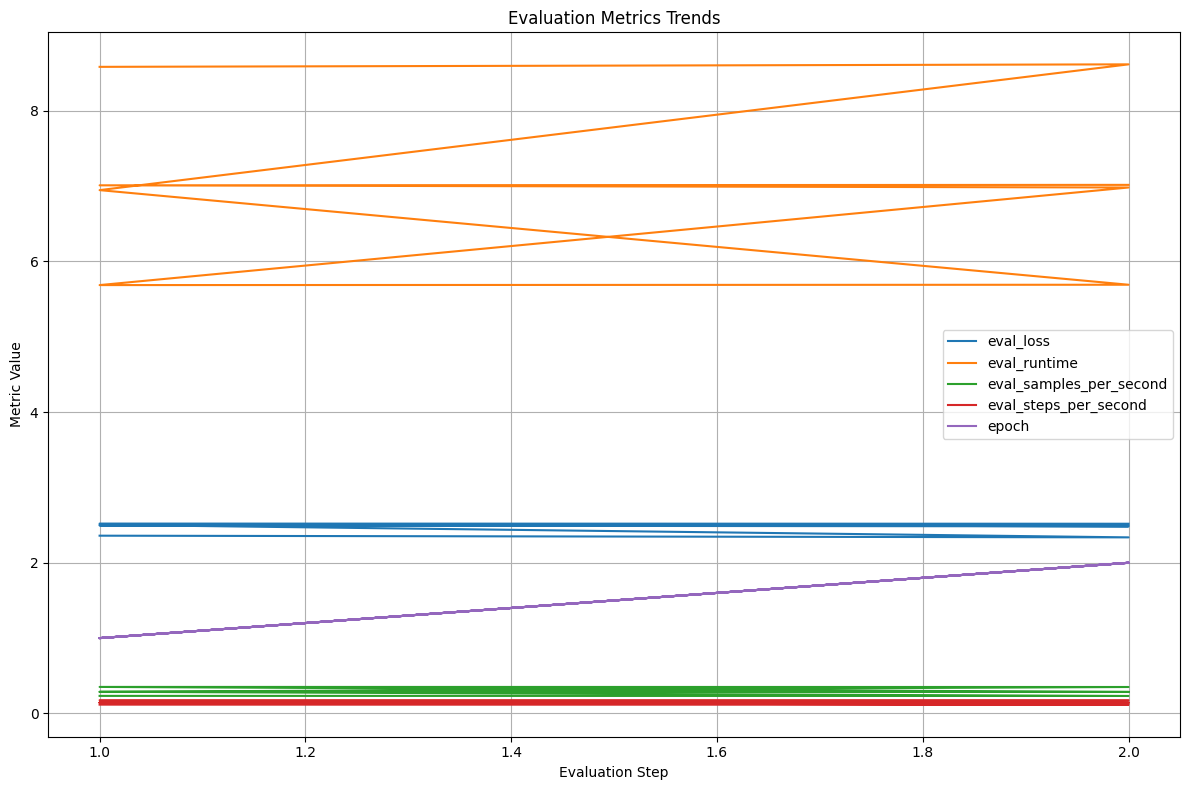

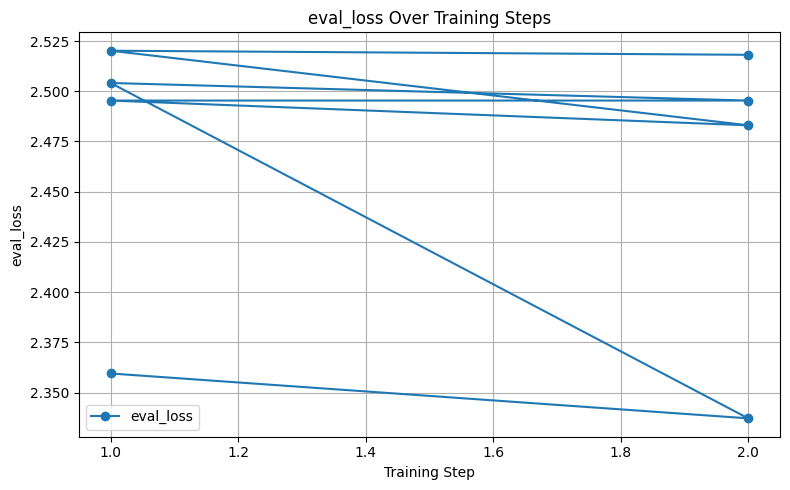

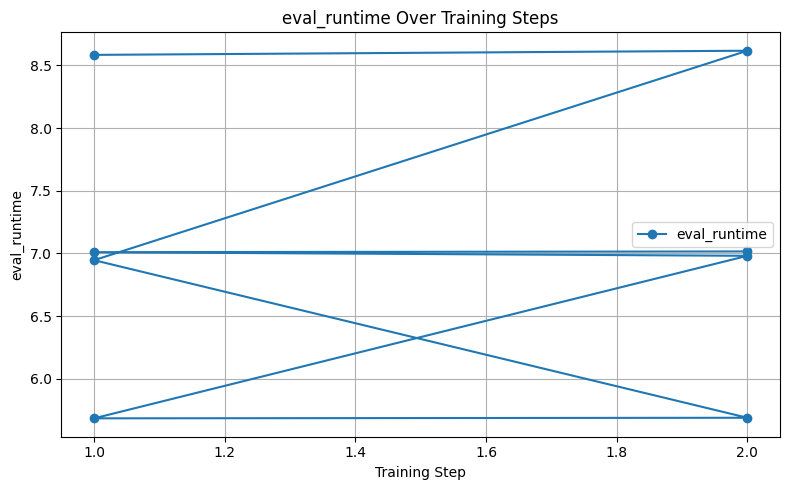

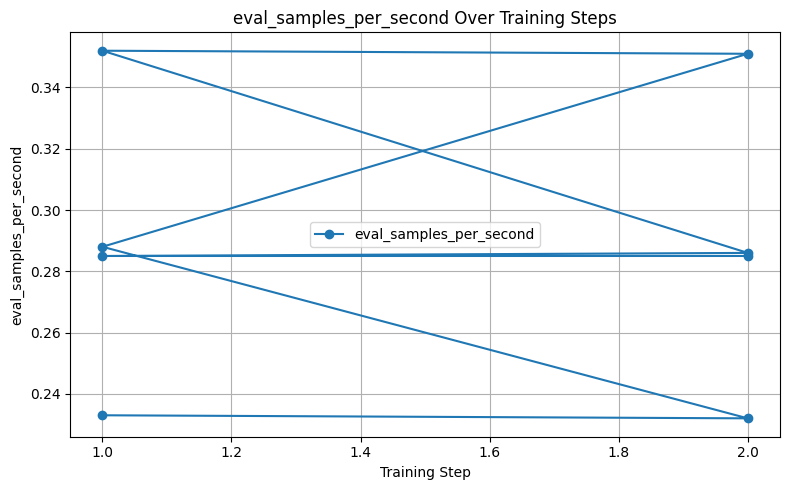

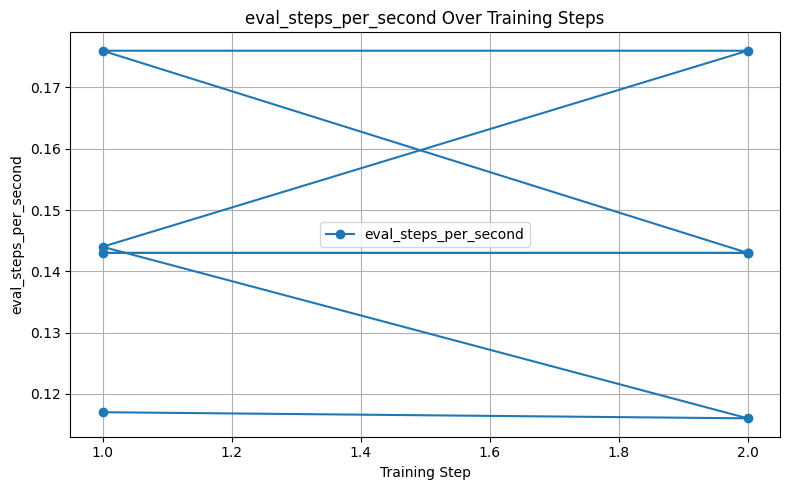

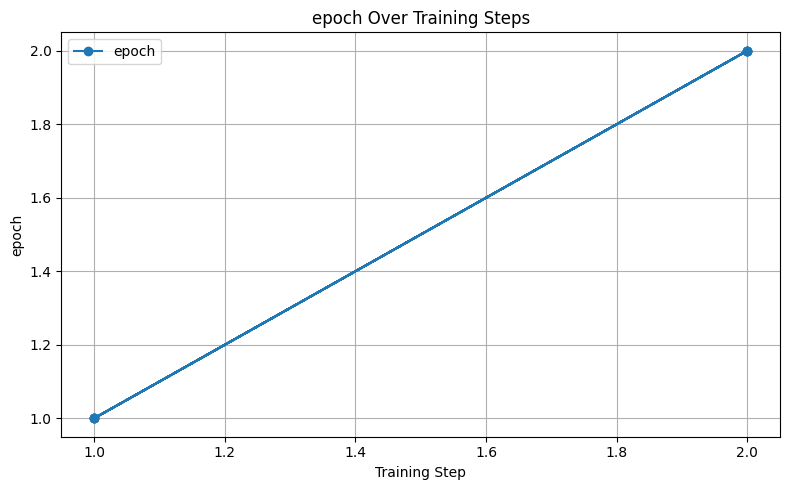

Saved trend plot for eval_loss to /mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit/checkpoints/eval_trend_plots/eval_loss.png
Saved trend plot for eval_runtime to /mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit/checkpoints/eval_trend_plots/eval_runtime.png
Saved trend plot for eval_samples_per_second to /mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit/checkpoints/eval_trend_plots/eval_samples_per_second.png
Saved trend plot for eval_steps_per_second to /mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit/checkpoints/eval_trend_plots/eval_steps_per_second.png
Saved trend plot for epoch to /mnt/c/Users/Rpipc/Desktop/llama/farbod/f_d/fine_tuned_models/unsloth/SRL_unsloth_Llama-3.2-3B-Instruct-bnb-4bit/checkpoints/eval_trend_plots/epoch.png


TypeError: Unsupported types (<class 'unsloth.models._utils.EmptyLogits'>) passed to `_pad_across_processes`. Only nested list/tuple/dicts of objects that are valid for `is_torch_tensor` should be passed.

In [22]:
# Load and plot the latest evaluation metrics
# a. Plot Metrics for Latest Evaluation Step
latest_eval_metrics = load_latest_eval_metrics(output_dir)
plot_and_save_metrics(latest_eval_metrics, output_dir, dataset_name="eval")

# b. Plot Trends Across All Evaluation Steps
log_path = os.path.join(output_dir, "eval_metrics_log.json")
plot_eval_trends(log_path)
save_eval_trends(log_path, output_dir)


# Generate predictions and metrics for the predict dataset
predictions = trainer.predict(tokenized_predict_dataset)
metrics = predictions.metrics

# c. Plot Metrics for Prediction Dataset
# Save and plot metrics for the predict dataset
metrics_path = os.path.join(main_results_path, "predict_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=4)
print(f"Metrics saved to {metrics_path}")
plot_and_save_metrics(metrics, main_results_path, dataset_name="predict")